#**1 Author**

**Student Name**: Sahib Bhatti
**Student ID**: 190319889

# **2 Problem formulation**

Using the full MLEND Yummy Dataset consisting of 3250 samples, I will create a dataframe of dishes containing rice and chips which I will take as input, where I will output a prediction of whether the picture of the dish contains rice or chips. Thus this is a binary classification problem.


#**3 Machine Learning pipeline**

I will begin by preprocessing the data. I will do this by cleaning it and extracting a dataset of solely rice and chips samples. I will then create the train and test datasets and encode them to 1 for rice, and 0 for chips. I will then test to see if my code outputs rice or chips images.

I will have three transformation stages. Firstly I will make all the images the same size to ensure they share the same dimensions. Then I will carry out features extraction to capture the most relevant details. Finally, I will normalise the features to bring them to a similar scale.

Then I will train and test with a linear model to predict the labels in the train and test dataset based on the predicted labels. I will also try a Random Forest Model. I will then compare outputs and accuracies and visualise them to make sense of them.

# **4 Transformation stage**




# Resizing Transformation

I will begin with resizing the images to make them all the same size. I will do this to ensure they all have the same dimensions of 150x150 pixels (square-shaped). This transformation will stretch or minimise the image until it fits within the dimensions. The input will be the x train of images of different sizes and the output will be x train where all images share the same size. A consistent size ensures same dimensions which enables learning of relevant patterns while avoiding bias, for more efficient processing.

In [18]:
from PIL import Image
from tqdm import tqdm

def process_images(paths, desc):
    processed_images = []

    for k, file in enumerate(tqdm(paths, desc=desc, unit="image")):
        img = Image.open(file)
        img = img.resize((max(img.size), max(img.size)), Image.LANCZOS)
        img = img.resize((150, 150), Image.LANCZOS)

        img_ar = np.array(img)

        if len(img_ar.shape) == 2:
            img_ar = np.stack((img_ar,) * 3, axis=-1)

        processed_images.append(img_ar)

    return np.array(processed_images)

X_train = process_images(X_train_paths_filtered, "loading train images")
print(f"X_train shape: {X_train.shape}")

X_test = process_images(X_test_paths_filtered, "loading test images")
print(f"X_test shape: {X_test.shape}")

loading train images: 100%|██████████| 656/656 [06:57<00:00,  1.57image/s]


X_train shape: (656, 150, 150, 3)


loading test images: 100%|██████████| 299/299 [02:58<00:00,  1.67image/s]

X_test shape: (299, 150, 150, 3)


Now let's plot a few images after resizing

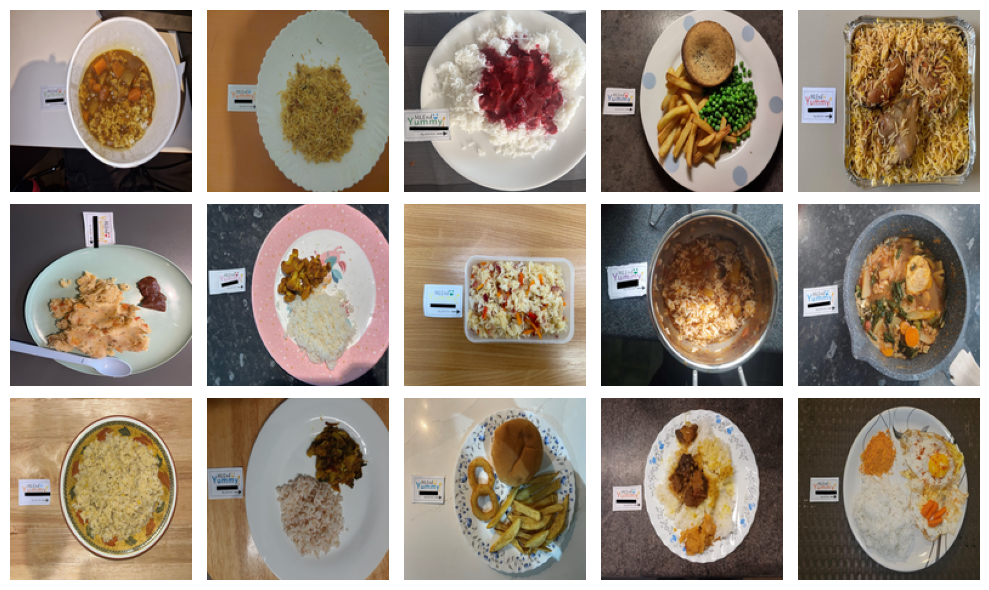

In [19]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

#Features Extraction

I will then carry out feature extraction. Each image will be described as 3x150x150 = 67,500 values meaning the predictor space has 67,500 dimensions. Since we don't have 67,500 training samples, I will use feature extraction to reduce the dimensionality of the predictor space and will look to extract 4 image features.

In the cell below, I define get_yellow_component and GMLC_features which altogether extract 4 features that will define a new predictor space.

In [20]:
#Features code

from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx


# I used 3 features from GMLC
def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0] # Measures average absolute difference between grey levels of a pixel and it's neighbour, where a higher dissimilarit means a higher texture dissimilarity
  f2 = graycoprops(glcm, 'correlation')[0, 0] # Measures the linear dependency between grey levels of a pixel and it's neighbour
  f3 = graycoprops(glcm, 'contrast')[0, 0] # Higher contrast value means higher level of variation

  return f1,f2, f3


def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

I have used the get_yellow_component feature as it calculates the number of yellow pixels in a image. This can distinguish both chips and rice, french fries are usually yellow and rice being white/brown or occasionally yellow.

I have used 3 features in GMLC. GMLC is a texture feature. F1 is the dissimilarity feature measuring the difference between grey levels of a pixel and of those next to it which is relevant as chips and rice should have different textures. F2 measures the linear dependency between grey levels of a pixel and those next to it meaning different textures in rice and chips may reflect different correlation patterns which can help separate the two. F3 is contrast which measures the level of varation in the grey levels, so if the contrast is higher, then there's higher variation which can be helpful if rice and chips have different levels if contrast.

Let us now extract the four features from each image and create the transform sets `X_train_f` and `X_test_f`

In [21]:
# Feature extraction for training set
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3, f4 = GMLC_features(I)
  X_train_f.append([f1,f2,f3,f4])

# Feature extraction for testing set
X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3, f4 = GMLC_features(I)
  X_test_f.append([f1,f2,f3,f4])

In [22]:
# Convert to np arrays and print their shapes
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape


((656, 4), (299, 4))

We can see that `X_train_f` represents a collection of 656 samples described by 4 attributes and `X_test_f` represent a collection of 299 samples described by 4 attributes. This feature extraction stage has reduced the dimensionality of our problem from 67,500D to 4D.

#Normalisation

Finally I will implement a normalisation stage (through standardisation) to ensure the 4 attributes in the prediction space all take a similar range of values.

In [23]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD

In [24]:
# Printing the first 10 X_train features normalised
X_train_fn[:10]

array([[-0.94259839, -0.89351023,  1.50153614, -0.67238674],
       [-0.13388813, -1.99567176,  0.64420571, -1.7993011 ],
       [ 0.36240458, -0.07884289,  1.00344047, -0.03653796],
       [-0.79149726,  1.0805051 , -0.65914946,  1.40154053],
       [ 0.337292  ,  1.09315079, -2.600936  ,  0.56379378],
       [-1.12391974, -0.51553703,  0.08666211,  0.06512877],
       [-0.70083658, -0.55044625,  0.97377811, -0.37518348],
       [-0.64635505, -1.02079601,  0.09311108, -1.04844069],
       [-1.13796576,  0.0884419 ,  0.42191681, -0.05494509],
       [-0.72935426,  0.23477156, -0.67492787, -0.29836509]])

#**5 Modelling**


I will train and test a linear model using the normalised attributes. After printing the accuracy in Methodology, I will explore a Random Forest Model to see if it can increase the accuracy. Random Forest is a good model as it can be used with a variety of different datasets.


#Linear model

Let's train and test a model which uses the normalised attributes above to predict whether the dish contains rice or chips.

My linear model is using 'Support Vector Machine' which produces a linear boundary in the prediction space.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

model = LinearSVC(C=1)
model.fit(X_train_fn, Y_train)

LinearSVC(C=1)

#**6 Methodology**

This section contains my training model, accuracy and confusion matrix.

I will train my model by firstly splitting the dataset into train and test dataset filtering it through column 'Benchmark_A' which classifies samples as train or test. I will then prepare the data for encoding by matching the filename and paths for X_train_paths_filtered and train_data, then doing the same for X_test_paths_filtered and test_data. Then I will label encode the data where rice = 1, and chips = 0.

Then after the transformation stages, I will fit the linear model on the training features normalised data and will use the model to predict the label for train and test. I will then extract the training and testing accuracy, and the per class accuracies through a confusion matrix to see if chips and rice were correctly classified.

I will repeat this with the Random Forest model.

**Create Test and Train Dataframes**

In [8]:
# import train_test_split function from sklearn to split dataset into train and test sets
from sklearn.model_selection import train_test_split
import os

In [9]:
# Filter rows where Benchmark_A = train and assign these samples to the train dataframe
train_data = df_filtered[df_filtered['Benchmark_A'] == 'Train']
# Filter rows where Benchmark_A = test and assign these samples to the test dataframe
test_data = df_filtered[df_filtered['Benchmark_A'] == 'Test']

In [10]:
# Load data and split into train and test sets according to Benchmark_A
TrainSet, TestSet, Map = yummy_load(datadir_main=datadir,train_test_split='Benchmark_A')

Total 3250 found in /content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/


In [11]:
#Extracting paths of images in training and testing sets
X_train_URL = TrainSet['X_paths']
X_test_URL = TestSet['X_paths']

In [12]:
# Filter paths in 'X_train_URL' based on whether the basename of the path is present in the index of 'train_data'
X_train_paths_filtered = [path for path in TrainSet['X_paths'] if os.path.basename(path) in train_data.index]

#Visually check if X_train_paths_filtered rows match to train_data rows
X_train_paths_filtered[:5]

['/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000001.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000021.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000022.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000024.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000026.jpg']

In [13]:
train_data[:5]

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,rice_chips
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,rice
000021.jpg,non_vegetarian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,rice
000022.jpg,vegetarian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,rice
000024.jpg,vegan,british,pie_and_chips,home,"mushroom_pie,chips,peas",neutral,3.0,like,4.0,Train,chips
000026.jpg,non_vegetarian,pakistani,chicken_biryani,home,"rice,chicken,biryani_masala,yogurt,oil,green_c...",healthy,4.0,strongly_like,5.0,Train,rice


**As you can see the outputs of the filename and paths match for X_train_paths_filtered and train_data**

In [14]:
# This list comprehension filters the paths in TrainSet['X_paths'] based on whether the corresponding filename (obtained with os.path.basename) is in the index of train_data.
X_test_paths_filtered = [path for path in TestSet['X_paths'] if os.path.basename(path) in test_data.index]

# Visually check if X_test_paths_filtered rows match to test_data rows
X_test_paths_filtered[:5]

['/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000010.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000016.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000020.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000038.jpg',
 '/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_images/000039.jpg']

In [15]:
#comparing if we get the same filenames from X_test_paths_filtered and test_data
test_data[:5]

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,rice_chips
filename,,,,,,,,,,,
000010.jpg,vegetarian,indian,spiced_mixed_vegetable_curry_with_bread_rolls,home,"potatoes,tomatoes,green_bell_peppers,onions,gr...",healthy,4.0,strongly_like,5.0,Test,chips
000016.jpg,vegan,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,rice
000020.jpg,vegetarian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,rice
000038.jpg,non_vegetarian,indian,rice_with_chicken_curry,home,"boiled_rice,chicken,sunflower_oil,chilli_powde...",healthy,4.0,strongly_like,5.0,Test,rice
000039.jpg,vegetarian,south_indian,khichidi,home,"rice,moong_lentils,ghee,cumin_seeds,ginger",very_healthy,5.0,like,4.0,Test,rice


In [16]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'rice_chips' column in train_data
Y_train = label_encoder.fit_transform(train_data['rice_chips'])
# Fit and transform the 'rice_chips' column in test_data
Y_test = label_encoder.fit_transform(test_data['rice_chips'])

print("\nY_train:")
print(Y_train[:15])
print("\nY test")
print(Y_test[:15])


Y_train:
[1 1 1 0 1 1 1 1 1 1 1 1 0 1 1]

Y test
[0 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


**Visualising five dishes that have rice and five dishes that have chips**

Rice
Chips


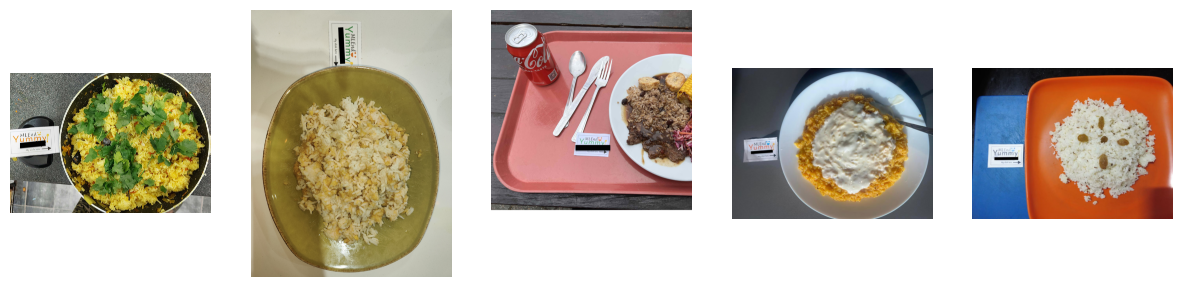

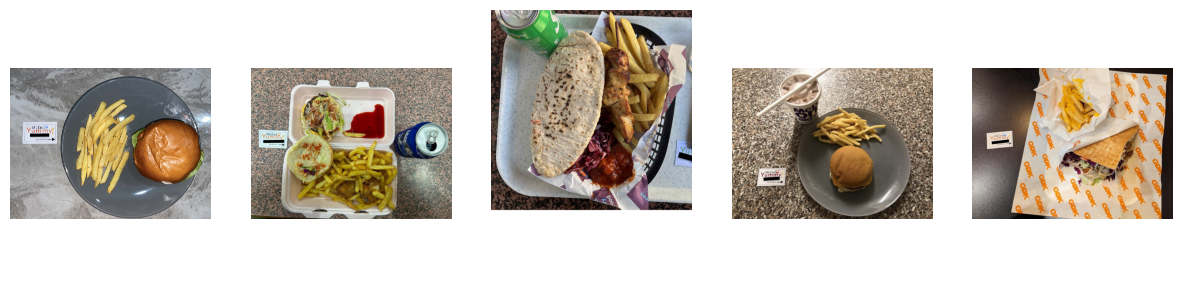

In [17]:
rice_image = np.array(X_train_paths_filtered) [Y_train==1]
chips_image = np.array(X_train_paths_filtered) [Y_train==0]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(rice_image[len(rice_image)-5:]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(chips_image[len(chips_image)-5:]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

#Linear Model Accuracy and confusion matrix

Let's use this training model to predict the labels in the training and testing datasets and calculate the train and test accuracy based on the predicted labels

In [26]:
ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp==Y_train)
test_accuracy  = np.mean(ysp==Y_test)

print('Training Accuracy:\t',train_accuracy)
print('Test  Accuracy:\t',test_accuracy)

Training Accuracy:	 0.8445121951219512
Test  Accuracy:	 0.8327759197324415


**Confusion matrix for Linear Model (training)**



Let's build a conufsion matrix to view the per-class accuracies for training





Training Linear Model Accuracy


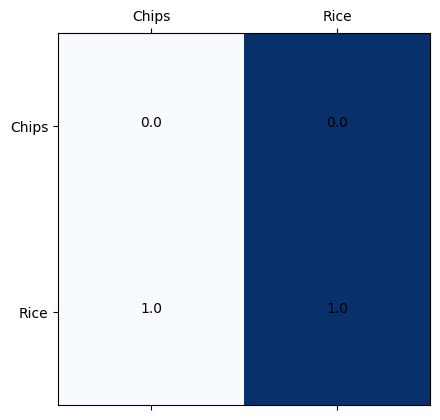

In [27]:
print("\nTraining Linear Model Accuracy")

Ac = np.mean(ytp[Y_train.astype(int)==0]==0)
Ar = np.mean(ytp[Y_train.astype(int)==1]==1)

Mc = np.mean(ytp[Y_train.astype(int)==0]==1)
Mr = np.mean(ytp[Y_train.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

**Confusion matrix for Linear Model (testing)**


Let's build a conufsion matrix to view the per-class accuracies for testing





Testing Linear Model Accuracy


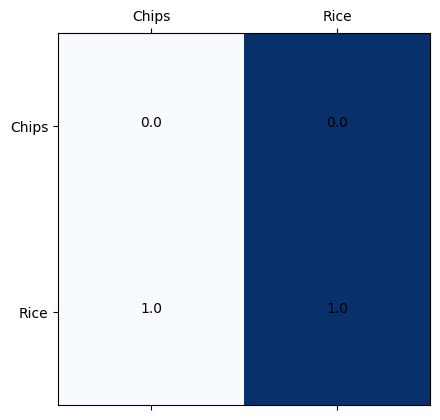

In [28]:
print("\nTesting Linear Model Accuracy")

Ac = np.mean(ysp[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

From both  the training and the testing confusion matrix chips we can see chips having a per class accuracy of 0 and rice having a per class accuracy of 1. This means that the chip images are all getting misclassified as rice. A reason for this is because the dataset is biased to rice since a total of 803 samples are rice, and 152 being chips according to my dataframe.

#Random Forest Model

Now I will carry out an experiment and attempt to fit the Random Forest model to see if we can improve our training and testing accuracies as well as our per class accuracies.

In [29]:
model = RandomForestClassifier(n_estimators=50,max_depth=40, random_state=7)
model.fit(X_train_fn, Y_train)
ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp==Y_train)
test_accuracy  = np.mean(ysp==Y_test)

print('Training Accuracy:\t',train_accuracy)
print('Test  Accuracy:\t',test_accuracy)

Training Accuracy:	 1.0
Test  Accuracy:	 0.8193979933110368


We can see that the Random Forest Model is overfitting as it is working perfectly on the training dataset, but not equally well on the test. We will continue this experiment in part **8 Results**.

#**7 Dataset**

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

In this section, I will preprocess the data, and create a dataset of rice and chip samples which I will use to create my models.

In [1]:
#Install mlend library and upgrade to latest version
!pip install mlend --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00


In [2]:
#Imports and mounting to drive
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp
from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Downloading and saving the Yummy dataset
import mlend
from mlend import download_yummy, yummy_load


datadir = download_yummy(save_to = '/content/drive/MyDrive/Data/MLEnd_big')

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


In [4]:
#Creating the dataframe from the csv and display its contents
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd_big/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test


**Dropping duplicate columns, cuisine and cuisine_org are the same**

In [5]:
MLENDYD_df = MLENDYD_df.drop(columns=['Cuisine_org'])

In [6]:
import pandas as pd

# Function to label dishes with rice, chips, or both based on Dish_name and Ingredients
def rice_chips_attribute(row):
    dish_name = row.iloc[2].lower()  # Assuming 'Dish_name' is the third column (index 2) after dropping cuisine_org
    ingredients = row.iloc[4].lower()  # Assuming 'Ingredients' is the fifth column (index 4) after dropping cuisine_org

    if 'rice' in dish_name or 'rice' in ingredients or 'biryani' in dish_name or 'biryani' in ingredients or 'pilau' in dish_name or 'pilau' in ingredients:
        return 'rice'
    elif 'chips' in dish_name or 'chips' in ingredients or 'fries' in dish_name or 'fries' in ingredients or 'potato wedges' in dish_name or 'potato wedges' in ingredients or 'wedges' in dish_name or 'wedges' in ingredients:
        return 'chips'
    else:
        return 'discard'

# Apply the function to create the new column
MLENDYD_df['rice_chips'] = MLENDYD_df.apply(rice_chips_attribute, axis=1)

# Filter out the discarded dishes
df_filtered = MLENDYD_df[MLENDYD_df['rice_chips'] != 'discard']

# Display the resulting DataFrame
df_filtered

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,rice_chips
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,rice
000010.jpg,vegetarian,indian,spiced_mixed_vegetable_curry_with_bread_rolls,home,"potatoes,tomatoes,green_bell_peppers,onions,gr...",healthy,4.0,strongly_like,5.0,Test,chips
000016.jpg,vegan,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,rice
000020.jpg,vegetarian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,rice
000021.jpg,non_vegetarian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,rice
...,...,...,...,...,...,...,...,...,...,...,...
003235.jpg,non_vegetarian,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,rice
003236.jpg,non_vegetarian,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,chips
003243.jpg,vegetarian,british,pan-fried_beef_with_rice,restaurant,"rice,corn,beef,red_cabbage",healthy,4.0,dislike,2.0,Train,rice


**Create rice and chips dataframe and view shape**

In [7]:
# Create the rice and chips dataframes
rice_samples = df_filtered[df_filtered['rice_chips'] == 'rice']
chips_samples = df_filtered[df_filtered['rice_chips'] == 'chips']

# Print the shapes
print("Shape of 'rice' category:", rice_samples.shape)
print("Shape of 'chips' category:", chips_samples.shape)

Shape of 'rice' category: (803, 11)
Shape of 'chips' category: (152, 11)


#**8 Results**

After receiving the training and testing accuracies of both our linear model and Random Forest Model in part **6 Methodology**, I decided to compute the confusion matrix of the Random Forest model here to attain the per class accuracies.

**Random Forest Confusion matrix for training**

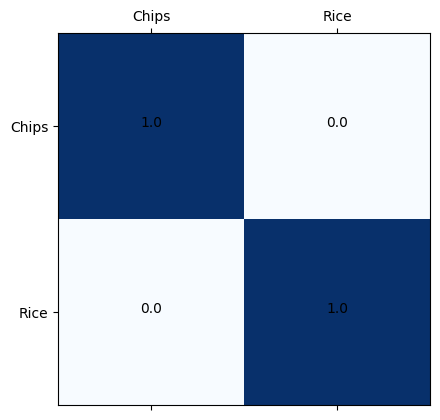

In [30]:
Ac = np.mean(ytp[Y_train.astype(int)==0]==0)
Ar = np.mean(ytp[Y_train.astype(int)==1]==1)

Mc = np.mean(ytp[Y_train.astype(int)==0]==1)
Mr = np.mean(ytp[Y_train.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

We can see that both the chips and rice are being correctly classified using this model on the training dataset. Now lets see how the images have been classified.

In [31]:
print(ytp)

[1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 

Here we can see the predictions for all the images from the dataset provided. You can see that this time, many dishes of chips were classified as chips and not misclassified as rice.

**Random Forest Confusion matrix for testing**

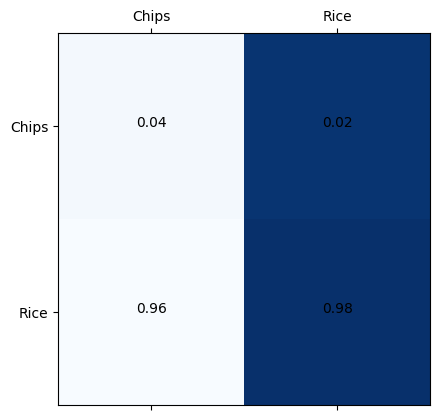

In [32]:
Ac = np.mean(ysp[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

In this confusion matrix for testing, we can see that I have an improvement of class accuracies for chips in comparison to the linear model confusion matrix (from part 6 Methodology). This is because the linear model was giving me per class accuracies of chips as 0.0 and rice as 1.0 meaning that all chips were being classified as rice. This compared to the 0.04 chips being correctly classified from this Random Forest model.

However, comparing our Random Forest testing per class accuracies to our Random Forest training accuracies, we can see that model is severely overfitting since in the training, all classes seem to be correctly classified.

Lets take a look to see how the images have been classified.

In [33]:
print(ysp)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1]


You can see that rice was predicted for most the images, however there were still some chips being predicted which is an improvement from the linear model.

#**9 Conclusions**

Due to the dataset being biased to rice dishes the linear model did not work very well. The Random Forest Classifier model is a better model to utilise to predict whether a dish has rice or chips based on the image but this will also need to be tweaked or improved to get better per class accuracies. Random Forest works better by the algorithm taking a 'forest' of decision trees, and taking and combining these decision trees to produce more accurate predictions. Due to the nature of the task, Random Forest being a non linear model could have been an advantage as it can can handle more complex relationships.

Another approach for next time can be to preprocess the data further so that the samples for rice or chips are weighted similar to increase fairness. This could potentially improve some aspects of model performance.

An improvement for next time would be to implement more models. One model which I think would help is the Gradient Boosting model since it can build trees sequentially, focusing on previous steps where samples were misclassified. This could make it less sensitive to biased data.

A final improvement could be to use more features so that the chips can be classified more accurately. For example, a feature for next time could be one which depicts the shape of the food on the dish.


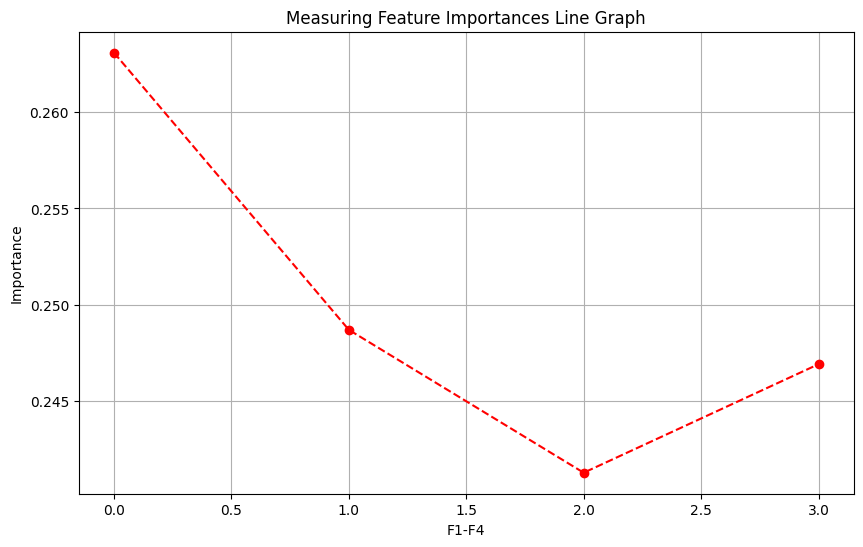

In [34]:
import matplotlib.pyplot as plt

# Assuming feature_importances is a list or array containing the importance values
feature_importances = model.feature_importances_

# Visualize feature importances with a line graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(feature_importances)), feature_importances, marker='o', color = 'red', linestyle='--')
plt.xlabel("F1-F4")
plt.ylabel("Importance")
plt.title("Measuring Feature Importances Line Graph")
plt.grid()
plt.show()

Here I have measured the importance of my 4 features. This would be useful in deciding which features should stay as they are impactful and which ones aren't needed.